In [1]:
from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf
from src.models.emos import BootstrapEmos, EMOS


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

2024-06-15 05:51:52.647893: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 05:51:52.650031: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 05:51:52.680809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 05:51:58.865328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
features_names = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in features_names}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
train_data_original, test_data, data_info = load_cv_data(3, features_names_dict)

train_data = train_data_original.shuffle(len(train_data_original))

train_data = train_data.batch(32)

train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
test_data_original = test_data

In [5]:
test_data = test_data.batch(len(test_data))

test_data = test_data.repeat()

test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_3'

climatology = Climatology.load(folder)

In [8]:
twcrps_bootstrap = BootstrapEmos.load('/net/pc200239/nobackup/users/hakvoort/models/bootstrap_emos/tn_ln_M13_STD2_C07')

crps_bootstrap = BootstrapEmos.load('/net/pc200239/nobackup/users/hakvoort/models/bootstrap_emos/crps')

In [9]:
x = np.arange(0.1, 20, 0.5)
x_shift = x + 0.2

In [ ]:
brier_model_1 = crps_bootstrap.Brier_Score(test_data, x)

brier_model_1_shift = crps_bootstrap.Brier_Score(test_data, x_shift)

brier_model_2_shift = twcrps_bootstrap.Brier_Score(test_data, x_shift)

In [ ]:
twcrps_scores_model_1 = crps_bootstrap.twCRPS(test_data, x, 500)

twcrps_scores_model_1_shift = crps_bootstrap.twCRPS(test_data, x_shift, 500)

twcrps_scores_model_2_shift = twcrps_bootstrap.twCRPS(test_data, x_shift, 500)

In [ ]:
brier_mean_model_1 = brier_model_1.mean(axis=1)
brier_mean_model_1_shift = brier_model_1_shift.mean(axis=1)

In [ ]:
bss_model_1 = 1 - brier_model_1 / brier_mean_model_1[:, np.newaxis]

bss_model_2 = 1 - brier_model_2_shift / brier_mean_model_1_shift[:, np.newaxis]

bss_model_1_mean = bss_model_1.mean(axis=1)
bss_model_1_std = bss_model_1.std(axis=1)

bss_model_2_mean = bss_model_2.mean(axis=1)
bss_model_2_std = bss_model_2.std(axis=1)

In [ ]:
twcrps_mean_model_1 = twcrps_scores_model_1.mean(axis=1)
twcrps_mean_model_1_shift = twcrps_scores_model_1_shift.mean(axis=1)

In [ ]:
twcrpss_model_1 = 1 - twcrps_scores_model_1 / twcrps_mean_model_1[:, np.newaxis]

twcrpss_model_2 = 1 - twcrps_scores_model_2_shift / twcrps_mean_model_1_shift[:, np.newaxis]

twcrpss_model_1_mean = twcrpss_model_1.mean(axis=1)
twcrpss_model_1_std = twcrpss_model_1.std(axis=1)

twcrpss_model_2_mean = twcrpss_model_2.mean(axis=1)
twcrpss_model_2_std = twcrpss_model_2.std(axis=1)

In [ ]:
brier_score_climatology = climatology.Brier_Score(test_data, x)
brier_score_climatology_shift = climatology.Brier_Score(test_data, x_shift)

twcrps_climatology = climatology.twCRPS(test_data, x, 500)
twcrps_climatology_shift = climatology.twCRPS(test_data, x_shift, 500)

In [ ]:
bss_model_1_climatology = 1 - brier_model_1 / brier_score_climatology[:, np.newaxis]
bss_model_1_climatology_shift = 1 - brier_model_1_shift / brier_score_climatology_shift[:, np.newaxis]
bss_model_2_climatology_shift = 1 - brier_model_2_shift / brier_score_climatology_shift[:, np.newaxis]

bss_model_1_mean_climatology = bss_model_1_climatology.mean(axis=1)
bss_model_1_std_climatology = bss_model_1_climatology.std(axis=1)

bss_model_1_mean_climatology_shift = bss_model_1_climatology_shift.mean(axis=1)
bss_model_1_std_climatology_shift = bss_model_1_climatology_shift.std(axis=1)

bss_model_2_mean_climatology_shift = bss_model_2_climatology_shift.mean(axis=1)
bss_model_2_std_climatology_shift = bss_model_2_climatology_shift.std(axis=1)

In [7]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_crps.pkl'

with open(filepath, 'rb') as f:
    model_1 = EMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_ln_M13_STD2_C07.pkl'

with open(filepath, 'rb') as f:
    model_2 = EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [8]:
models_emos = {'tn_CRPS': model_1, 'ml_tn_ln_M13_STD2_C07': model_2}

only_model_2 = {'tn_ln_M13_STD2_C07': model_2}

In [12]:
filepath = '/net/pc200239/nobackup/users/hakvoort/hyperopt/hyperopt_emos/'

study = optuna.load_study(study_name='twcrps_obj_CRPS_twCRPS12_MOTPE', storage=f'sqlite:///{filepath}/study.db')
study.set_metric_names(['CRPS', 'twCRPS12'])

/tmp/ipykernel_1773989/3987058584.py:4: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(['CRPS', 'twCRPS12'])


In [13]:
study_so = optuna.load_study(study_name='twcrps_obj_twCRPS12_MOTPE_pretrain_train_amount_1_final', storage=f'sqlite:///{filepath}/study.db')

In [35]:
df_so = study_so.trials_dataframe()
print(df_so.columns)

new_column_names_so = {
    'params_chain_function_mean': 'cf_mean',
    'params_chain_function_std': 'cf_std',
    'params_chain_function_constant': 'cf_constant',
    'user_attrs_CRPS': 'CRPS',
    'value': 'twCRPS12',
    'params_forecast_distribution': 'forecast_distribution',
    'params_distribution_1': 'distribution_1',
    'params_distribution_2': 'distribution_2',
    'params_epochs': 'epochs',
    'params_learning_rate': 'learning_rate',
    'params_batch_size': 'batch_size',
    'params_optimizer': 'optimizer'
}

df_so.rename(columns=new_column_names_so, inplace=True)

df_so[['CRPS']] /= 3

top_so = df_so.sort_values('twCRPS12').head(8)

Index(['number', 'value', 'datetime_start', 'datetime_complete', 'duration',
       'params_batch_size', 'params_chain_function_constant',
       'params_chain_function_mean', 'params_chain_function_std',
       'params_distribution_1', 'params_distribution_2', 'params_epochs',
       'params_forecast_distribution', 'params_learning_rate',
       'params_optimizer', 'params_perform_batching', 'user_attrs_CRPS',
       'user_attrs_run_0loss_fold_1_', 'user_attrs_run_0loss_fold_2_',
       'user_attrs_run_0loss_fold_3_', 'user_attrs_twCRPS12', 'state'],
      dtype='object')


In [15]:
df = study.trials_dataframe()

new_column_names = {
    'params_chain_function_mean': 'cf_mean',
    'params_chain_function_std': 'cf_std',
    'params_chain_function_constant': 'cf_constant',
    'values_CRPS': 'CRPS',
    'values_twCRPS12': 'twCRPS12',
    'params_forecast_distribution': 'forecast_distribution',
    'params_distribution_1': 'distribution_1',
    'params_distribution_2': 'distribution_2',
    'params_epochs': 'epochs',
    'params_learning_rate': 'learning_rate',
    'params_batch_size': 'batch_size',
    'params_optimizer': 'optimizer'
}

df.rename(columns=new_column_names, inplace=True)

In [16]:
study2 = optuna.load_study(study_name='twcrps_obj_CRPS_twCRPS12_MOTPE_pretrain_train_amount_1_final', storage=f'sqlite:///{filepath}/study.db')
study2.set_metric_names(['CRPS', 'twCRPS12'])

/tmp/ipykernel_1773989/1814083283.py:2: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study2.set_metric_names(['CRPS', 'twCRPS12'])


In [17]:
df2 = study.trials_dataframe()

df2.rename(columns=new_column_names, inplace=True)

In [18]:
length = 8
top_CRPS = df.sort_values('CRPS').head(length)
top_twCRPS12 = df.sort_values('twCRPS12').head(length)

top_CRPS_2 = df2.sort_values('CRPS').head(length)
top_twCRPS12_2 = df2.sort_values('twCRPS12').head(length)

top_CRPS[['CRPS', 'twCRPS12']] /= 3
top_twCRPS12[['CRPS', 'twCRPS12']] /= 3

In [19]:
pareto_front = study.best_trials
best_runs = [trial.number for trial in pareto_front]

pareto_trials = df['number'].isin(best_runs)

my_run = df[pareto_trials]

In [20]:
pareto_front2 = study2.best_trials
best_runs2 = [trial.number for trial in pareto_front2]

pareto_trials2 = df['number'].isin(best_runs2)

my_run_2 = df2[pareto_trials2]

In [21]:
params = ['cf_mean',
           'cf_std', 
           'cf_constant',
             'forecast_distribution', 
             'distribution_1',
              'distribution_2',
                'CRPS',
             'twCRPS12',
             ]

all_params = ['cf_mean',
           'cf_std', 
           'cf_constant',
             'forecast_distribution', 
             'distribution_1',
              'distribution_2',
              'batch_size',
              'epochs',
              'learning_rate',
              'optimizer',
                'CRPS',
             'twCRPS12',
             ]

In [22]:
pareto = my_run.sort_values('CRPS')
pareto2 = my_run_2.sort_values('CRPS')

pareto[['CRPS', 'twCRPS12']] /= 3



In [23]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

early_stopping_1 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_50_early_stopping_1', train_data)
early_stopping_2 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_50_early_stopping_2', train_data)
early_stopping_3 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_50_early_stopping_3', train_data)
early_stopping_4 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_50_early_stopping_4', train_data)
early_stopping_5 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_50_early_stopping_5', train_data)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 142 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


In [24]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'


no_early_stopping_1 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_37_no_early_stopping_1', train_data)
no_early_stopping_2 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_37_no_early_stopping_2', train_data)
no_early_stopping_3 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_37_no_early_stopping_3', train_data)
no_early_stopping_4 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_37_no_early_stopping_4', train_data)
no_early_stopping_5 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_37_no_early_stopping_5', train_data)
no_early_stopping_6 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_37_no_early_stopping_6', train_data)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


In [25]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

nn_tn_M9_STD1_C01_ES_1 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_1_constant_0.01_trunc_normal_epochs_70_early_stopping_1', train_data)
# best epoch 55

nn_tn_M9_STD1_C01_ES_2 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_1_constant_0.01_trunc_normal_epochs_70_early_stopping_2', train_data)
# best epoch 52

nn_tn_M10_STD01_C001_ES_1 = NNForecast.my_load(filepath + 'twCRPS_mean_10_std_0.01_constant_0.001_trunc_normal_epochs_80_early_stopping_1', train_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


In [26]:
tn_M9_STD1_C01_ES_models = {
    'nn_tn_M9_STD1_C01_ES_1': nn_tn_M9_STD1_C01_ES_1,
    'nn_tn_M9_STD1_C01_ES_2': nn_tn_M9_STD1_C01_ES_2
}

nn_CRPS_and_twCRPS_models = {
    'nn_tn_M9_STD1_C01_ES_1': nn_tn_M9_STD1_C01_ES_1,
    'nn_tn_M9_STD1_C01_ES_2': nn_tn_M9_STD1_C01_ES_2,
    'nn_tn_CRPS_ES_1': early_stopping_3,
    'nn_tn_CRPS_ES_2': early_stopping_2,
}

In [10]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_ln_M13_STD2_C07.pkl'

with open(filepath, 'rb') as f:
    lin_reg_ml_tn_ln_M13_STD2_C07 = EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [16]:
print(lin_reg_ml_tn_ln_M13_STD2_C07.CRPS(test_data, 90000))

tf.Tensor(0.8897301, shape=(), dtype=float32)


In [28]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos/batching/'

emos_base = load_model(filepath + 'crps_batch_none_epochs_600')

early_stopping_models = {
    'nn_early_stopping_1' : early_stopping_1,
        'nn_early_stopping_2' : early_stopping_2,
    'nn_early_stopping_3' : early_stopping_3,
    'nn_early_stopping_4' : early_stopping_4,
        'nn_early_stopping_5' : early_stopping_5,
        'lin_reg_ml_tn_ln_M13_STD2_C07': lin_reg_ml_tn_ln_M13_STD2_C07,

}

early_stopping_with_emos = {
       'nn_early_stopping_1' : early_stopping_1,
        'nn_early_stopping_2' : early_stopping_2,
    'nn_early_stopping_3' : early_stopping_3,
    'nn_early_stopping_4' : early_stopping_4,
        'nn_early_stopping_5' : early_stopping_5,
    'lin_reg_ml_tn_ln_M13_STD2_C07': lin_reg_ml_tn_ln_M13_STD2_C07,
    'lin_reg_tn_CRPS': emos_base,
}

Using given parameters for Truncated Normal distribution


In [29]:
no_early_stopping_models = {
    'no_early_stopping_1' : no_early_stopping_1,
        'no_early_stopping_2' : no_early_stopping_2,
    'no_early_stopping_3' : no_early_stopping_3,
    'no_early_stopping_4' : no_early_stopping_4,
        'no_early_stopping_5' : no_early_stopping_5,
        'no_early_stopping_6': no_early_stopping_6,
        #'lin_reg_ml_tn_ln_M13_STD2_C07': lin_reg_ml_tn_ln_M13_STD2_C07,

}

no_early_stopping_with_emos = {
       'no_early_stopping_1' : early_stopping_1,
        'no_early_stopping_2' : early_stopping_2,
    'no_early_stopping_3' : early_stopping_3,
    'no_early_stopping_4' : early_stopping_4,
        'no_early_stopping_5' : early_stopping_5,
        'no_early_stopping_6': no_early_stopping_6,
    'lin_reg_ml_tn_ln_M13_STD2_C07': lin_reg_ml_tn_ln_M13_STD2_C07,
    'lin_reg_tn_CRPS': emos_base,
}

## Work of the past weeks

- Impelemented bootstrapping for EMOS with linear regression

- Implemented climatology

- Trained neural networks with longer training times (leads to overfitting)

- Implemented early stopping for neural networks

- Implemented the peephole correctly

- Experimented with (MO)TPE



## Results for bootstrapping emos

Bootstrapping shows that the results for EMOS are relatively stable, especially in the Brier skill score. The twCRPSS plot shows simalar behaviour. Again the twCRPSS is still more unstable for high thresholds, something that is not as clearly seen in the Brier skill score plot. This is most likely because I sample from the underlying distribution to estimate the twCRPS. The tails of the distributions that lie in the extremes can then not be properly estimated.

In [ ]:
plt.errorbar(x, bss_model_1_mean, yerr=bss_model_1_std,  capsize=2, color='blue', label='CRPS_tn')
plt.errorbar(x_shift, bss_model_2_mean, yerr=bss_model_2_std, capsize=2, color='red', label='twCRPS_M13_STD2_C07_ml_tn_ln')

plt.xlim(0, 20)
plt.xlabel('Threshold')
plt.ylabel('Brier Skill Score')
plt.title('Brier Skill Scores')
plt.legend()
plt.show()

In [ ]:
plt.errorbar(x, twcrpss_model_1_mean, yerr=twcrpss_model_1_std,  capsize=2, color='blue', label='CRPS_tn')
plt.errorbar(x_shift, twcrpss_model_2_mean, yerr=twcrpss_model_2_std, capsize=2, color='red', label='twCRPS_M13_STD2_C07_ml_tn_ln')

plt.xlabel('Threshold')
plt.ylabel('twCRPSS')
plt.title('twCRPSS Scores')
plt.xlim(0, 20)
plt.legend()
plt.show()

In [ ]:
plt.errorbar(x_shift, bss_model_2_mean_climatology_shift, yerr=bss_model_2_std_climatology_shift, label='twCRPS_M13_STD2_C07_ml_tn_ln', color='red')
plt.errorbar(x, bss_model_1_mean_climatology, yerr=bss_model_1_std_climatology, label='CRPS_tn', color='blue')

# plot a straight line from 0, 0 to 20, 0, dashed and black
plt.plot([0, 20], [0, 0], 'k--', label='climatology')
plt.xlim([0, 20])
plt.title('Brier Skill Scores, with climatology')
plt.legend()
plt.show()

There are 423 values in the PIT diagram


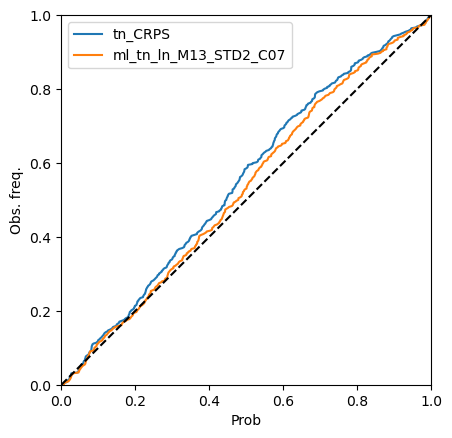

In [37]:
t = 12
make_cpit_diagram_tf(models_emos, test_data_original, t=t)

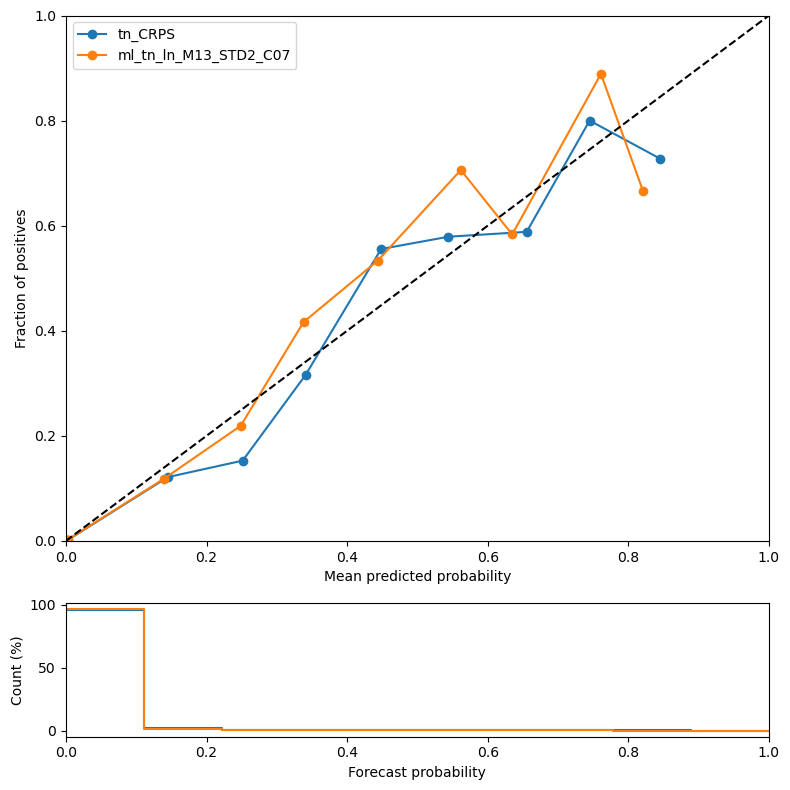

In [38]:
t = 15
make_reliability_and_sharpness_tf(models_emos, test_data, t=t)

## Experimented with MOTPE

Implemented MOTPE, where I optimized over the following variables:

- Mean and std of the Gaussian cdf and constant, for the weight function $w(z) = c + \Phi_{\mu, \sigma}(z)$. 
The values where $c \in [0.00001, 2], \mu \in [-5, 15]$ and $\sigma \in [0.0001, 10]$

- Learning rate, between 0.0001 and 0.1.

- Optimizer, SGD or Adam.

- Forecast distribution, TN, LN, GEV or a mixture/mixture linear.

- Batch size, $2^i$, where $i \in \{5,6,...,10\}$ or equal to the entire dataset.

- Number of epochs, between 100 and 500.

I performed three fold cross-validation. Three different tables, one with the top configurations for optimizing CRPS, one for twCRPS12 and one for the pareto front. In total 175 different configurations were tested. 

The runs with a mixture linear distribution are also partially influenced by luck, certain times these perform better.


#### Best CRPS configurations

In [30]:
display(top_CRPS[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_1,distribution_2,batch_size,epochs,learning_rate,optimizer,CRPS,twCRPS12
171,-3.828661,1.485626,0.000203,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,432,0.008282,Adam,0.898339,0.059386
160,-2.897627,3.120845,0.000129,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,420,0.014094,Adam,0.898670,0.059638
164,-1.096566,1.823862,0.000185,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,417,0.011224,Adam,0.899479,0.059462
73,8.145216,7.913398,0.000104,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,315,0.011094,Adam,0.900389,0.059595
168,-3.234054,3.584374,0.000153,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,424,0.007340,Adam,0.900712,0.059751
162,1.424215,1.919470,0.000244,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,456,0.000859,Adam,0.900897,0.060159
77,11.201177,7.358788,0.000272,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,329,0.010963,Adam,0.901061,0.059693
161,-4.099851,3.046601,0.000133,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,425,0.014476,Adam,0.901320,0.060070


#### Best twCRPS12 configurations

In [31]:
display(top_twCRPS12[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_1,distribution_2,batch_size,epochs,learning_rate,optimizer,CRPS,twCRPS12
60,10.816164,1.785932,0.000210,distr_trunc_normal,NaN,NaN,128.0,290,0.011949,Adam,0.948377,0.058723
166,11.197616,1.662136,0.000015,distr_trunc_normal,NaN,NaN,256.0,413,0.009754,Adam,0.960121,0.058820
111,10.476087,0.000453,0.000302,distr_trunc_normal,NaN,NaN,128.0,276,0.009472,Adam,1.009833,0.058934
114,10.971715,0.960693,0.000144,distr_mixture,distr_log_normal,distr_trunc_normal,128.0,255,0.003802,Adam,0.992229,0.059010
54,12.199493,1.329734,0.000066,distr_trunc_normal,NaN,NaN,128.0,324,0.007627,Adam,1.010528,0.059017
120,10.775414,1.627839,0.000229,distr_trunc_normal,NaN,NaN,128.0,141,0.012980,Adam,0.953129,0.059057
172,10.817245,1.401593,0.000381,distr_trunc_normal,NaN,NaN,128.0,270,0.008895,Adam,0.958928,0.059110
50,11.881624,1.164704,0.000083,distr_trunc_normal,NaN,NaN,128.0,264,0.005036,Adam,1.011706,0.059192


#### Pareto front

In [32]:
display(pareto[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_1,distribution_2,batch_size,epochs,learning_rate,optimizer,CRPS,twCRPS12
171,-3.828661,1.485626,0.000203,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,432,0.008282,Adam,0.898339,0.059386
75,9.197862,2.935806,0.000895,distr_mixture_linear,distr_trunc_normal,distr_gev,128.0,418,0.010750,Adam,0.911084,0.059254
133,10.426935,2.914051,0.000202,distr_trunc_normal,NaN,NaN,128.0,292,0.013319,Adam,0.919057,0.059211
60,10.816164,1.785932,0.000210,distr_trunc_normal,NaN,NaN,128.0,290,0.011949,Adam,0.948377,0.058723


### TPE for twCRPS12

I also ran the TPE algorithm for a single objective, namely twCRPS12. A total of 110 trials were performed. The top runs for twCRPS12 are in the table below.

In [36]:
display(top_so[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_1,distribution_2,batch_size,epochs,learning_rate,optimizer,CRPS,twCRPS12
104,9.140137,0.685503,0.000917,distr_trunc_normal,NaN,NaN,256.0,340,0.005623,Adam,0.939814,0.059062
45,10.562909,0.033929,0.000120,distr_trunc_normal,NaN,NaN,64.0,227,0.007439,Adam,1.031725,0.059073
70,7.730364,0.083086,0.000250,distr_trunc_normal,NaN,NaN,32.0,266,0.003153,Adam,0.929338,0.059124
106,8.958219,0.887471,0.002142,distr_trunc_normal,NaN,NaN,256.0,344,0.003083,Adam,0.931956,0.059174
91,8.922766,0.113570,0.000126,distr_trunc_normal,NaN,NaN,256.0,374,0.002721,Adam,0.941504,0.059181
92,10.556690,0.406234,0.000175,distr_trunc_normal,NaN,NaN,256.0,309,0.001455,Adam,0.967047,0.059226
110,9.163368,1.065727,0.002047,distr_trunc_normal,NaN,NaN,64.0,381,0.005943,Adam,0.935134,0.059228
109,8.951666,1.443687,0.001924,distr_trunc_normal,NaN,NaN,64.0,341,0.005845,Adam,0.930334,0.059259


Results seem promising, but I think I should include more trials. Also, to get a better idea of how replicable these results are, I want to train 2 or 3 models on each fold and then take the average CRPS/twCRPS12. 

I also think that this algorithm will work better with less hyperparameters. Maybe fix the learning rate and number of epochs?

Question: how to proceed?

## Peephole

I implemented the peephole simalar to Daniel. I concatenate the HA40 wind speed forecast with the output of the final dense layer, before giving $\mu$ and $\sigma$ for the parametric distribution. Daniel also included the spatial variance, I currently don't plan on doing this.

## Implemented Early Stopping

I implemented early stopping. In the following, I trained 4 neural networks, where the loss on a validation set was used for early stopping. The loss function is the CRPS, the parametric distribution is TN and I used a patience of 10 epochs. The optimal weights were at the following epochs

- model 1: epoch 37

- model 2: epoch 39  

- model 3: epoch 31

- model 4: epoch 40

- model 5: epoch 37




This plot contains the BSS relative to EMOS with linear regression trained on the CRPS with TN distribution

244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


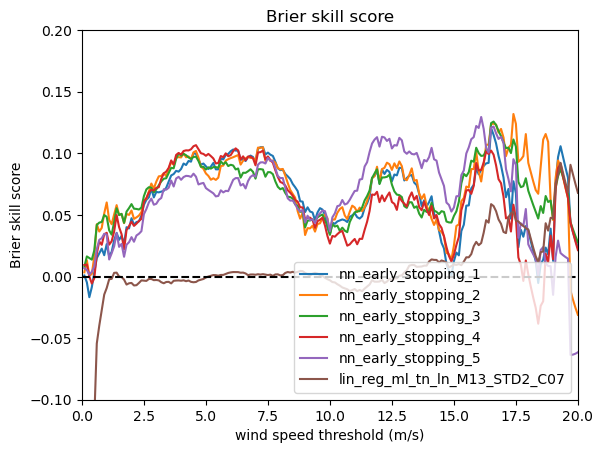

In [21]:
values = np.linspace(0.1, 20, 200)
ylim = [-0.1, 0.2]
#ylim = [-0.2, 1]
make_brier_skill_plot_tf(emos_base, early_stopping_models, test_data, values, ylim=ylim)

And this plot compares the models with climatology

244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


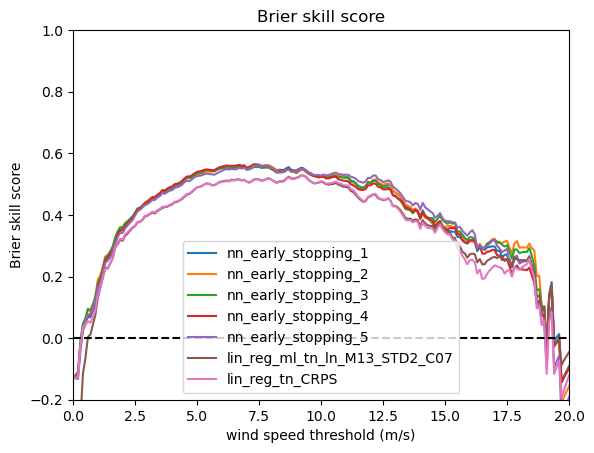

In [23]:
values = np.linspace(0.1, 20, 200)
ylim = [-0.2, 1]
make_brier_skill_plot_tf(climatology, early_stopping_with_emos, test_data, values, ylim=ylim)

I then trained 6 models with the same configuration for 37 epochs. The results now vary much more.

244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


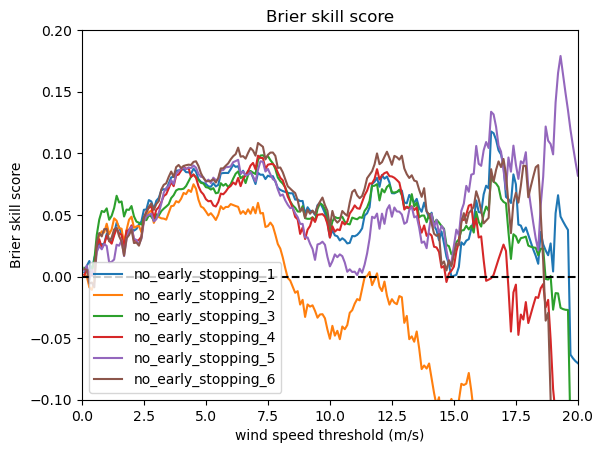

In [42]:
values = np.linspace(0.1, 20, 200)
ylim = [-0.1, 0.2]
#ylim = [-0.2, 1]
make_brier_skill_plot_tf(emos_base, no_early_stopping_models, test_data, values, ylim=ylim)

Since early stopping significantly stabilises the results, I think I will also use this for hyperparameter optimization (and not let the number of epochs be a hyperparameter itself). However I still need to decide how I choose the number of epochs of the final model. Maybe the following plan:

First find optimal setup where I use early stopping

When I found the best configuration, train this model multiple times on the folds, again with early stopping

See at which number of epochs the best weights are found with the validation set

Train the final model on all the traning data, with $2/3$ the optimal number of epochs found in the previous step.

## Training on twCRPS

I also trained models on the twCRPS with early stopping, with as scoring rule $w(z) = 0.01 + \Phi_{\mu,\sigma}(z)$ with $\mu = 9$ and $\sigma = 1$. It seems like the effect is smaller than EMOS with linear regression. The optimal epochs were now 55 and 52. 

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


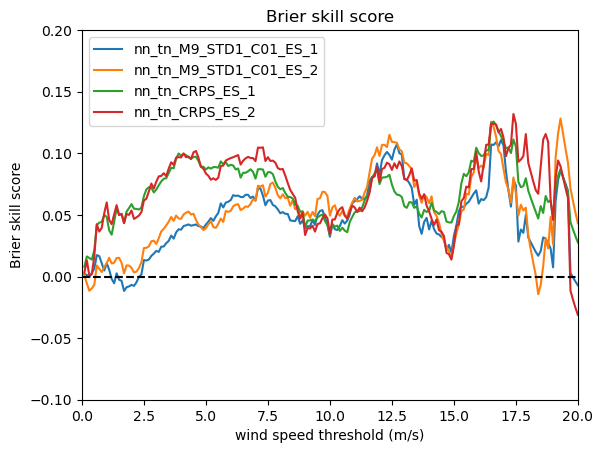

In [59]:
values = np.linspace(0.1, 20, 200)
ylim = [-0.1, 0.2]
make_brier_skill_plot_tf(emos_base, nn_CRPS_and_twCRPS_models, test_data, values, ylim=ylim)

## Bagging or Bootstrapping

Because there is still a lot of variance between different runs, I need to decide how to report the final results. The improvement of using weighted scoring rules is relatively small, so maybe instead of showing BSS and twCRPSS plots with bootstrapping statistics, I could make a bagging model. Then the (possible) improvement of using weighted scoring rules can be made clearer.

## Plan Moving Forward

- Have a discussion with Chibeb (second reader) about importance sampling and see if this changes performance for neural networks

- Implement MOTPE where I take the average of two or three runs for EMOS with linear regression. Also include more trials.

- Implement MOTPE for CNNs, with early stopping. Could also take the average scores over 2 or 3 models per fold. Variables that I want to optimize:

    - For the twCRPS, the choice of $c \in [0, 2]$, $\mu \in [-5, 15]$ and $\sigma \in [0.001, 5]$, for the weight function $$w(z) = c + \Phi_{\mu,\sigma}(z).$$  

    - Forecast distribution, TN, LN or mixture of TN-LN.

    - <del> Number of epochs, between 1 and 50. </del>

    - Batch size, ${8, 16, 32, 64, 128, 256}$.

    - <del> Input grid size of the wind speed NWP forecast, $\{11, 16, 21, ..., 36\}$. </del>

    - <del> Number of $7\times 7$ convolutional blocks. </del>

    - <del> Number of $5\times 5$ convolutional blocks. </del>

    - <del> Number of $3\times 3$ convolutional blocks. </del>

    - Number of dense layers, between 1 and 5.

    - Number of units in each dense layer, between 10 and 200.

    - Learning rate in the Adam optimizer.

    - Value of $l_2$ regression.

- Start producing the final results, where I train EMOS with linear regression and CNNs with the hyperparameters found during hyperparameter optimization.

Maybe plan a meeting 2 or 3 weeks? July 1, or 8/9 July